In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

In this notebook, we calculate the mean average precision to identify replicable perturbations and then for retrieving gene-compound pairs for deep learning based features. The following are the steps taken.
1. Augmented ORF, CRISPR and Compound profiles for replicate plates are merged into a single data frame and are spherized separately.
2. Empty wells are removed from all the plates.
3. mAP is calculated for the task of replicate retrieval (replicability). mAP for a random baseline is subtracted.
4. Negcon wells are removed.
5. Median consensus profiles are created for all perturbations.
6. Non-replicable perturbations are removed (mean AP ≤ 0)
7. Additional target annotations are added to the compound profiles.
8. 8. mAP is calculated for the task of compound-compound pair retrieval (those targeting the same gene). mAP for a random baseline is subtracted.
9. Genes that are targeted by compounds but are not targeted in the genetic perturbation experiments, are removed.
10. mAP is calculated for the task of gene-compound pair retrieval (biological consistency). mAP for a random baseline is subtracted.
11. Tables of mAP values are printed and bar plots of mAP values are plotted.

In [2]:
replicability_df = pd.DataFrame()
compound_compound_matching_df = pd.DataFrame()
gene_compound_matching_df = pd.DataFrame()

feature_to_group_by = "Metadata_broad_sample"
batch = "2020_11_04_CPJUMP1_DL"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            # Read all the plates
            data_df = (
                utils.load_data(batch, plate, "spherized.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        # Set Metadata_broad_sample value to "DMSO" for DMSO wells
        modality_1_df[feature_to_group_by].fillna("DMSO", inplace=True)

        # Remove empty wells
        modality_1_df = utils.remove_empty_wells(modality_1_df)

        # time
        time_1 = utils.time_point(modality_1_perturbation, modality_1_timepoint)

        # Calculate replicability mAP
        replicability_precision = utils.PrecisionScores(modality_1_df, modality_1_df, feature_to_group_by, within=True, challenge_negcon=True)

        replicability_df = replicability_df.append({'Description':f'{modality_1_perturbation}_{cell}_{modality_1_timepoint}',
                                                    'Modality':f'{modality_1_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'time':f'{time_1}',
                                                    'mAP':f'{replicability_precision.map:.3f}'}, ignore_index=True)

        # Remove DMSO wells
        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)

        # Create consensus profiles
        modality_1_consensus_df = utils.consensus(modality_1_df, feature_to_group_by)

        # Filter out non-replicable compounds
        compound_precision_df = replicability_precision.ap_group
        replicable_compounds = list(compound_precision_df.query("ap>0")[feature_to_group_by])
        modality_1_consensus_df = modality_1_consensus_df.query('Metadata_broad_sample==@replicable_compounds').reset_index(drop=True)

        # Adding additional gene annotation metadata
        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
            .assign(Metadata_gene=lambda x: x.Metadata_target_list.str.split('|'))
            .assign(Metadata_gene_list=lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_gene')
            .reset_index(drop=True)
        )

        # Filter out genes with less than two compounds
        gene_with_at_least_two_compounds = list(modality_1_consensus_df.groupby('Metadata_gene').Metadata_broad_sample.apply(lambda x: len(x)).reset_index().query('Metadata_broad_sample > 1')['Metadata_gene'])
        modality_1_consensus_matching_df = modality_1_consensus_df.query('Metadata_gene==@gene_with_at_least_two_compounds').reset_index(drop=True)

        # Calculate compound-compound matching
        compound_compound_precision = utils.PrecisionScores(modality_1_consensus_matching_df, modality_1_consensus_matching_df, "Metadata_gene", within=True)

        compound_compound_matching_df = compound_compound_matching_df.append({'Description':f'{cell}_{time_1}',
                                                                              'Modality': f'{modality_1_perturbation}',
                                                                              'Cell': f'{cell}',
                                                                              'time':f'{time_1}',
                                                                              'mAP':f'{compound_compound_precision.map:.3f}'}, ignore_index=True)

        all_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in all_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = all_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "spherized.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_gene_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_2_df, data_df)

                # Remove empty wells
                modality_2_df = utils.remove_empty_wells(modality_2_df)

                # time
                time_2 = utils.time_point(modality_2_perturbation, modality_2_timepoint)

                # Calculate replicability mAP
                replicability_precision = utils.PrecisionScores(modality_2_df, modality_2_df, feature_to_group_by, within=True, challenge_negcon=True)

                replicability_df = replicability_df.append({'Description':f'{modality_2_perturbation}_{cell}_{modality_2_timepoint}',
                                                    'Modality':f'{modality_2_perturbation}',
                                                    'Cell':f'{cell}',
                                                    'time':f'{time_2}',
                                                    'mAP':f'{replicability_precision.map:.3f}'}, ignore_index=True)


                # Remove negcon wells
                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                # Create consensus profiles
                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")

                # Filter out non-replicable genes
                precision_df = replicability_precision.ap_group
                replicable_genes = list(precision_df.query("ap>0")[feature_to_group_by])
                modality_2_consensus_df = modality_2_consensus_df.query('Metadata_broad_sample==@replicable_genes').reset_index(drop=True)

                # Filter out compounds without a paired genetic perturbation
                modality_2_genes = list(np.unique(list(modality_2_consensus_df.Metadata_gene)))
                modality_1_consensus_df = modality_1_consensus_df.query('Metadata_gene==@modality_2_genes').reset_index(drop=True)

                # Calculate biological consistency mAP

                gene_compound_precision = utils.PrecisionScores(modality_1_consensus_df, modality_2_consensus_df, "Metadata_gene", anti_correlation=True)

                gene_compound_matching_df = gene_compound_matching_df.append({'Description':f'{modality_1_perturbation}_{time_1} vs. {modality_2_perturbation}_{time_2}',
                                                                              'Modality1': f'{modality_1_perturbation}_{time_1}',
                                                                              'Modality2': f'{modality_2_perturbation}_{time_2}',
                                                                              'Cell': cell,
                                                                              'mAP':f'{gene_compound_precision.map:.3f}'}, ignore_index=True)


In [4]:
# Remove duplicate entries
replicability_df.drop_duplicates(inplace=True)

Replicability mAP

In [5]:
print(replicability_df[['Description', 'time', 'mAP']].to_markdown(index=False))

| Description      | time   |   mAP |
|:-----------------|:-------|------:|
| compound_U2OS_48 | long   | 0.532 |
| crispr_U2OS_144  | long   | 0.32  |
| orf_U2OS_96      | long   | 0.277 |


Compound-compound matching mAP

In [6]:
print(compound_compound_matching_df[['Description', 'time', 'mAP']].to_markdown(index=False))

| Description   | time   |   mAP |
|:--------------|:-------|------:|
| U2OS_long     | long   | 0.011 |


Gene-compound matching mAP

In [7]:
print(gene_compound_matching_df[['Description', 'mAP']].to_markdown(index=False))

| Description                   |   mAP |
|:------------------------------|------:|
| compound_long vs. crispr_long | 0.027 |
| compound_long vs. orf_long    | 0.037 |


In [8]:
replicability_df['mAP'] = replicability_df['mAP'].astype(float)
compound_compound_matching_df['mAP'] = compound_compound_matching_df['mAP'].astype(float)
gene_compound_matching_df['mAP'] = gene_compound_matching_df['mAP'].astype(float)

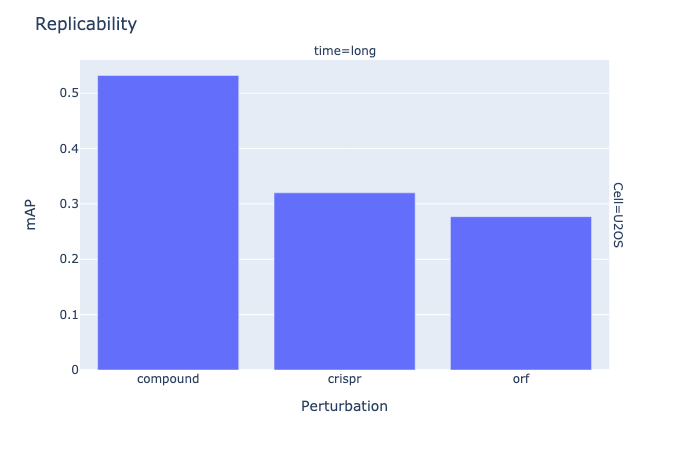

In [9]:
fig = px.bar(data_frame=replicability_df,
             x='Modality',
             y='mAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='Replicability',
                  xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/2.DeepProfiler_replicability.png', width=640, height=480, scale=2)

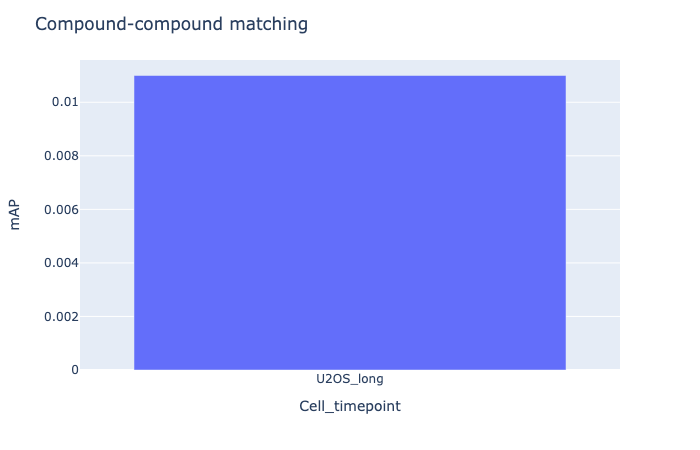

In [10]:
fig = px.bar(data_frame=compound_compound_matching_df,
             x='Description',
             y='mAP')
fig.update_layout(title='Compound-compound matching',
                  xaxis=dict(title='Cell_timepoint'),
                  yaxis=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.DeepProfiler_compound_compound_matching.png', width=640, height=480, scale=2)

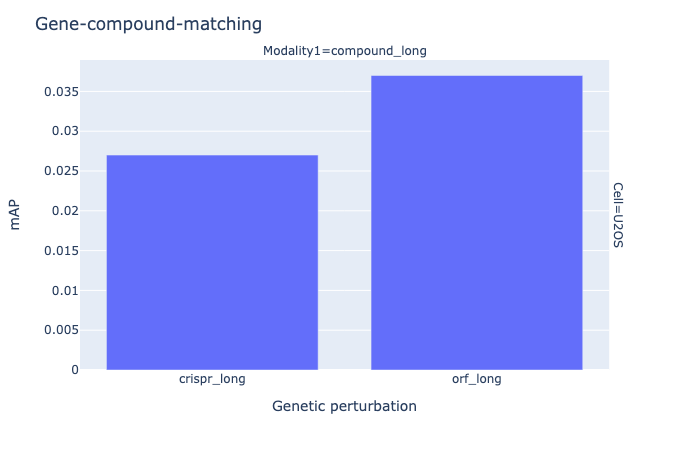

In [11]:
fig = px.bar(gene_compound_matching_df,
             x='Modality2',
             y='mAP',
             facet_col='Modality1',
             facet_row='Cell')
fig.update_layout(title='Gene-compound-matching',
                  xaxis1=dict(title='Genetic perturbation'),
                  xaxis2=dict(title='Genetic perturbation'),
                  yaxis1=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/2.DeepProfiler_gene_compound_matching.png', width=640, height=480, scale=2)

In [12]:
replicability_df[['Modality','Cell','time','mAP']].to_csv('output/deepprofiler_replicability.csv', index=False)
compound_compound_matching_df[['Modality', 'Cell', 'time', 'mAP']].to_csv('output/deepprofiler_compound_compound_matching.csv', index=False)
gene_compound_matching_df[['Modality1', 'Modality2', 'Cell', 'mAP']].to_csv('output/deepprofiler_gene_compound_matching.csv', index=False)